# Finance Fundamentals

A Jupyter notebook that computes fundamental and technical metrics of a given company.

## Loading Modules

### Basic

In [1]:
import os
import sys
import time

import numpy as np
from math import pi

### Data Handling and Cleaning

In [2]:
import pandas as pd
import requests

In [3]:
pd.set_option('display.max_columns', None) # displaying all columns!

Ensuring all Pipelines output `pandas.DataFrame`, globally!

In [4]:
# from sklearn import set_config

# set_config(transform_output="pandas") # globally!

### Data Visualization and Analysis

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

from IPython.display import display

In [8]:
# very pretty plots!
plt.style.use('fivethirtyeight')

# Override aggressive elements
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

Defining the colors and the palette:

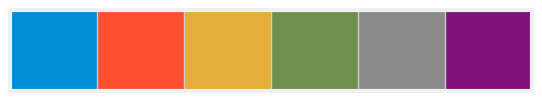

In [9]:
colors_538 = plt.rcParams['axes.prop_cycle'].by_key()['color']
palette_538 = sns.color_palette()

sns.palplot(palette_538)

Putting the the `matplotlib` verbosity at the `warning` level or above (_i.e._, `error` and `critical`):

In [10]:
plt.set_loglevel('WARNING')

Computing the size of an object:

In [12]:
def get_object_size(obj):
    """
    Compute size of object (in bytes).
    """
    if isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
        try:
            return obj.memory_usage(deep=True).sum()
        except:
            return sys.getsizeof(obj)
    return sys.getsizeof(obj)

### Finance Modules

In [15]:
# import edgar as ed
import yfinance as yf

## Company Facts

In [16]:
# SEC requires a User-Agent identifying your app/contact:contentReference[oaicite:5]{index=5}.
HEADERS = {
    "User-Agent": "ManuelBuenAbad (manuelbuenabadnajar@gmail.com)",
    "Accept-Encoding": "gzip, deflate"
}

### Scraping `SEC` for CIK

We briefly scrape the SEC website to read the CIK (Central Index Key) of a given company's ticker.

In [20]:
# get all company data (CIK [Central Index Key], ticker, and name)
companyTickers = requests.get(
    "https://www.sec.gov/files/company_tickers.json",
    headers=HEADERS
    )

# dictionary to dataframe
companyIDs = pd.DataFrame.from_dict(companyTickers.json(),
                                    orient='index')

# add leading zeros to CIK
companyIDs['cik_str'] = companyIDs['cik_str'].astype(
                           str).str.zfill(10)

In [21]:
companyIDs.head()

,cik_str,ticker,title
0,0001045810,NVDA,NVIDIA CORP
1,0000789019,MSFT,MICROSOFT CORP
2,0000320193,AAPL,Apple Inc.
3,0001018724,AMZN,AMAZON COM INC
4,0001652044,GOOGL,Alphabet Inc.


Defining the appropriate function:

In [22]:
def cik_from_ticker(ticker, compid_df=companyIDs):
    """
    Retrieves the CIK (Central Index Key) for a given stock ticker symbol.

    This function looks up the CIK associated with a provided ticker symbol using a reference DataFrame (e.g., one from the SEC's EDGAR data).

    Parameters
    ----------
    ticker : str
        The stock ticker symbol to look up (e.g., "AAPL").
    compid_df : pd.DataFrame, default companyIDs
        A DataFrame containing at least the columns "ticker" and "cik_str", used to map tickers to their corresponding CIKs.

    Returns
    -------
    str
        The CIK string corresponding to the given ticker.

    Raises
    ------
    IndexError
        If the ticker is not found in `compid_df`.
    """
    
    company = compid_df[compid_df["ticker"]==ticker]
    return company.cik_str.iloc[0]

### Company concepts from `yfinance`

#### Concepts

First, we define a dictionary of equivalent names (_i.e._ "synonyms") for the same concepts. This dictionary may need to be constantly updated as we find more and more synonyms for different companies.

In [23]:
SYNONYMS = {
        'net_income': ["Net Income", "Net Income Loss", "Profit Loss"],
        'total_assets': ["Total Assets"],
        'cfo': ["Operating Cash Flow", "Net Cash Provided by Operating Activities"],
        'current_assets': ["Total Current Assets", "Current Assets"],
        'current_liab': ["Total Current Liabilities", "Current Liabilities"],
        'long_term_debt': ["Long Term Debt", "Long-term Debt", "Long-Term Debt"],
        'rev': ["Total Revenue", "Revenues"],
        'cogs': ["Cost Of Revenue", "Cost of Goods Sold"],
        'shares_out': ["Common Stock Shares Outstanding", "Shares Outstanding", "Ordinary Shares Number"]
    }

Now, we write a function that extracts the value(s) of a concept from a company's dataframe indexed by that concept, by searching in the concept's list of synonyms.

In [25]:
def get_item(df: pd.DataFrame,
             synonyms: list=SYNONYMS):
    """
    Retrieves a row from a DataFrame using a list of possible index name synonyms.

    This function searches for the first matching synonym in the DataFrame index and returns the corresponding row. It is useful for extracting data when row labels may vary in name (e.g., "Revenue", "Total Revenue", "Net Sales").

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to search, typically with row labels in the index (e.g., financial line items).
    synonyms : list of str, default SYNONYMS
        A list of possible row names to try in order. The first match is returned.

    Returns
    -------
    pd.Series
        The row in the DataFrame corresponding to the first matching synonym.

    Raises
    ------
    KeyError
        If none of the synonyms are found in the DataFrame index.
    """

    for name in synonyms:
        if name in df.index:
            # pick all columns of the df row indexed by the name found
            return df.loc[name,:]
        else:
            continue
    
    raise KeyError(f"None of {synonyms} found in DataFrame index.")

#### Piotroski F-score

In [27]:
def compute_piotroski(fs, bs, cf,
                      syn=SYNONYMS):
    """
    Compute the Piotroski F-score based on financial statement data.

    The Piotroski F-score is a value investing metric composed of 9 binary signals grouped into three categories: profitability, leverage/liquidity, and operating efficiency. This function calculates all 9 signals and their sum (the final F-score).

    It expects three annual financial statement DataFrames with line items as the index and years as columns.

    Parameters
    ----------
    fs : pd.DataFrame
        The income statement (financial statement) DataFrame.
    bs : pd.DataFrame
        The balance sheet DataFrame.
    cf : pd.DataFrame
        The cash flow statement DataFrame.
    syn : dict, default SYNONYMS
        A dictionary mapping semantic line-item keys (e.g., 'net_income', 'rev') to lists of possible names used in the financial statements.

    Returns
    -------
    f_score : int
        The total Piotroski F-score (0 to 9).
    score_components : dict
        A dictionary with individual binary signals for:
        - Profitability (`f1_` to `f4_`)
        - Leverage/Liquidity (`f5_` to `f7_`)
        - Operating Efficiency (`f8_` to `f9_`)

    Raises
    ------
    ValueError
        If fewer than two years of data are available.
    KeyError
        If any required line item cannot be found in the input DataFrames using the provided synonyms.
    """

    # (1) Pull current and prior values
    years = fs.columns.tolist()
    if len(years) < 2:
        raise ValueError("At least two years of data required.")
    curr, prev = years[0], years[1]    

    # (2) Computing the Piotroski F-score:

    # (2.a) Profitability

    # net income (current year)
    ni_curr = get_item(fs, syn['net_income'])[curr]

    # total assets (current year)
    ta_curr = get_item(bs, syn['total_assets'])[curr]

    # total assets (previous year)
    ta_prev = get_item(bs, syn['total_assets'])[prev]

    # total assets (two years prior)
    ta_2yrs = get_item(bs, syn['total_assets'])[years[2]]

    # total assets (current yearly mean)
    ta_mean_curr = (ta_curr + ta_prev)/2

    # total assets (previous yearly mean)
    ta_mean_prev = (ta_prev + ta_2yrs)/2

    # ROA (return on assets) (current year)
    roa_curr = ni_curr / ta_curr

    # ROA (previous year)
    roa_prev = get_item(fs, syn['net_income'])[prev] / get_item(bs, syn['total_assets'])[prev]

    # CFO (cash flow from operating activities) (current year)
    cfo_curr = get_item(cf, syn['cfo'])[curr]

    # profitability score
    f_profit = {
        'f1_roa_positive': int(roa_curr > 0),
        'f2_cfo_positive': int(cfo_curr > 0),
        'f3_roa_improved': int(roa_curr > roa_prev),
        'f4_cfo_gt_ni': int(cfo_curr > ni_curr),
    }

    # (2.b) Leverage, liquidity & source of funds

    # long-term debt + current liabilities (current year)
    tl_curr = get_item(bs, syn['long_term_debt'])[curr] + get_item(bs, syn['current_liab'])[curr]

    # long-term debt + current liabilities (previous year)
    tl_prev = get_item(bs, syn['long_term_debt'])[prev] + get_item(bs, syn['current_liab'])[prev]

    # leverage (current & previous year)
    lev_curr, lev_prev = tl_curr / ta_curr, tl_prev / ta_prev

    # current assets (current year)
    ca_curr = get_item(bs, syn['current_assets'])[curr]

    # current assets (previous year)
    ca_prev = get_item(bs, syn['current_assets'])[prev]

    # current liabilities (current year)
    cl_curr = get_item(bs, syn['current_liab'])[curr]

    # current liabilities (previous year)
    cl_prev = get_item(bs, syn['current_liab'])[prev]

    # shares outstanding (current year)
    shares_curr = get_item(bs, syn['shares_out'])[curr]

    # shares outstanding (previous year)
    shares_prev = get_item(bs, syn['shares_out'])[prev]

    # leverage, liquidity, and source of funds score
    f_leverage = {
        'f5_de_leveraged': int(lev_curr < lev_prev),
        'f6_curr_ratio_up': int((ca_curr / cl_curr) > (ca_prev / cl_prev)),
        'f7_no_new_shares': int(shares_curr <= shares_prev),
    }

    # (2.c) Operating efficiency

    # revenue (current year)
    rev_curr = get_item(fs, syn['rev'])[curr]

    # revenue (previous year)
    rev_prev = get_item(fs, syn['rev'])[prev]

    # COGS (cost of goods sold) (current year)
    cogs_curr = get_item(fs, syn['cogs'])[curr]

    # COGS (previous year)
    cogs_prev = get_item(fs, syn['cogs'])[prev]

    # gross margin (current year)
    gm_curr = (rev_curr - cogs_curr) / rev_curr

    # gross margin (previous year)
    gm_prev = (rev_prev - cogs_prev) / rev_prev

    # asset turnover ratio (current year)
    at_curr = rev_curr / ta_mean_curr

    # asset turnover ratio (previous year)
    at_prev = rev_prev / ta_mean_prev

    # operating efficiency score
    f_eff = {
        'f8_gm_improved': int(gm_curr > gm_prev),
        'f9_at_improved': int(at_curr > at_prev),
    }

    # (2.d) Total F-score
    
    f_score = sum(f_profit.values()) + sum(f_leverage.values()) + sum(f_eff.values())

    # (3) Return final scores
    
    return f_score, {**f_profit, **f_leverage, **f_eff}

#### Stock's metrics

In [86]:
def compute_stock_metrics(ticker: str,
                          verbose_Fscore: bool=False,
                          technical: bool=False,
                          analysis: bool=False) -> pd.DataFrame:
    """
    Fetch and compute key stock metrics, including fundamentals, Piotroski F-score, and optionally technical and analyst-based indicators.

    This function pulls financial statement data using `yfinance`, computes the  Piotroski F-score, and optionally adds technical momentum and Wall Street  recommendation metrics. The result is returned as a one-row `DataFrame`.

    Parameters
    ----------
    ticker : str
        Stock ticker symbol (e.g., "AAPL", "TSLA").
    verbose_Fscore : bool, default False
        If True, includes individual Piotroski F-score components as columns.
    technical : bool, default False
        If True, includes technical indicators such as price, volume, moving averages, and 1-year momentum.
    analysis : bool, default False
        If True, includes analyst metrics such as price target, EPS, and number of analyst ratings.

    Returns
    -------
    pd.DataFrame
        A one-row DataFrame containing the selected stock metrics.

    Raises
    ------
    KeyError
        If required financial line items are not found in the financial statements.
    ValueError
        If fewer than two years of financial statement data are available.
    """

    tkr = yf.Ticker(ticker)
    info = tkr.info

    # Basic identifiers
    sector = info.get('sector', None)
    industry = info.get('industry', None)
    # cik    = info.get('cik', None)
    cik = cik_from_ticker(ticker)

    # Market cap
    market_cap = info.get('marketCap', None)
    market_cap_M = np.round(market_cap/(1.e6),3)

    # beta
    beta  = info.get('beta', None)

    # Grab annual statements
    fs = tkr.financials           # income statement ( = tkr.income_stmt)
    bs = tkr.balance_sheet        # balance sheet
    cf = tkr.cashflow             # cash flow

    # Piotroski F-Score
    f_score, f_components = compute_piotroski(fs, bs, cf)

    # Base result
    data = {
        'ticker': ticker,
        'cik': cik,
        'sector': sector,
        'industry': industry,
        'cap_M': market_cap_M,
        'beta': beta,
        'fscore': f_score,
    }
    # Add each component if you like:
    if verbose_Fscore:
        data.update(f_components)

    # --- Optional technical analysis block
    if technical:
        
        # Get most recent 1 year history
        hist = tkr.history(period="1y")
        
        close = hist['Close'].iloc[-1]
        vol   = hist['Volume'].iloc[-1]
        last_dt = hist.index[-1]

        # Moving averages
        ma50 = hist['Close'].rolling(window=50).mean().iloc[-1] # 50-day
        ma200= hist['Close'].rolling(window=200).mean().iloc[-1] # 200-day
        
        # Momentum: 12-month price change pct
        mom = (close / hist['Close'].iloc[0] - 1) * 100

        # Updating result
        data.update({
            'tmstp': last_dt.tz_convert('America/New_York'),
            'price': close,
            'volume': vol,
            'ma50': ma50,
            'ma200': ma200,
            'moment_1y_pct': mom,
        })

    # --- Optional analyst/“equity” analysis block
    if analysis:
        
        # yfinance info fields, if available
        target = info.get('targetMeanPrice', None)
        reco_mean = info.get('recommendationMean', None)
        n_analysts= info.get('numberOfAnalystOpinions', None)
        eps_trail = info.get('trailingEps', None)
        eps_fwd   = info.get('forwardEps', None)

        # Updating result
        data.update({
            'target_mean_price': target,
            'recommendation_mean': np.round(reco_mean,2),
            'num_analysts': n_analysts,
            'eps_trailing': eps_trail,
            'eps_forward': eps_fwd,
        })

    # Wrap into DataFrame
    df = pd.DataFrame([data])

    # Return dataframe
    return df

In [85]:
df = compute_stock_metrics("BLDR", technical=True, analysis=True)
display(df)
del df

,ticker,cik,sector,industry,cap_M,beta,fscore,tmstp,price,volume,ma50,ma200,moment_1y_pct,target_mean_price,recommendation_mean,num_analysts,eps_trailing,eps_forward
0,BLDR,0001316835,Industrials,Building Products & Equipment,14691.865,1.7,4,2025-07-11 00:00:00-04:00,132.940002,428383,115.8284,147.01615,-9.4969,139.7915,1.71,20,7.8,11.65


#### Candlesticks

In [188]:
from pandas.tseries.holiday import USFederalHolidayCalendar

Let us begin by creating a list of us holidays that fall within a certain time interval:

In [198]:
def get_us_federal_holidays(start: str, end: str, market_hours_offset: bool=True) -> list:
    """
    Return a list of U.S. federal holidays between two dates, optionally offset to market open time.

    This function uses `pandas.tseries.holiday.USFederalHolidayCalendar` to find holidays between the given start and end dates (inclusive), and optionally adjusts them to align with standard U.S. market open time (9:30 AM).

    Parameters
    ----------
    start : str
        Start date in 'YYYY-MM-DD' format.
    end : str
        End date in 'YYYY-MM-DD' format.
    market_hours_offset : bool, default True
        If True, offset each holiday date to 9:30 AM (U.S. market open time).

    Returns
    -------
    list
        A list of holiday dates between `start` and `end`. If `market_hours_offset` is True,
        each date is a `Timestamp` with time set to 9:30 AM. Otherwise, the list contains strings
        in 'YYYY-MM-DD' format.
    """

    # Getting the US Holiday Calendar
    cal = USFederalHolidayCalendar()

    # Obtaining a first list of US holidays in between those two dates
    holidays = cal.holidays(start=start, end=end)

    # To standard time format:
    holidays = holidays.strftime('%Y-%m-%d').tolist()

    # Offsetting by the market open hours:
    if market_hours_offset:
        holidays = [pd.to_datetime(hd) + pd.offsets.Hour(9) + pd.offsets.Minute(30) for hd in holidays]
    
    return holidays

Creating the plot:

In [200]:
# pulling the history of the ticker
history = yf.Ticker("AAPL").history(period="1mo", interval="1h", prepost=False)

# computing the US holidays that fell within the given history
us_holidays = get_us_federal_holidays(history.index[0], history.index[-1])

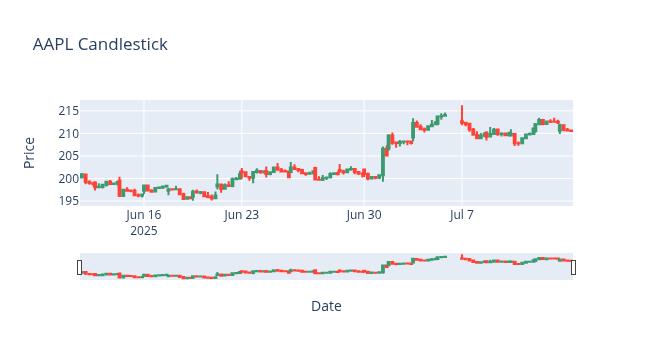

In [201]:
fig = go.Figure(data=[
    go.Candlestick(
        x=history.index,
        open=history['Open'],
        high=history['High'],
        low=history['Low'],
        close=history['Close']
    )
])

# Remove weekend gaps
fig.update_xaxes(
    rangebreaks=[dict(bounds=["sat", "mon"]),
                 dict(pattern="hour", bounds=[16, 9.5]),
                 dict(values=us_holidays)])

fig.update_layout(title="AAPL Candlestick", xaxis_title="Date", yaxis_title="Price")

fig.show()

In [202]:
del history, us_holidays, fig